In [ ]:
# the below code is adapted/inspired from https://huggingface.co/blog/patchtst and https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/util.py

In [1]:
# pip install git+https://github.com/IBM/tsfm.git
# pip install transformers
# pip install bottleneck --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import EarlyStoppingCallback, PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

In [2]:
dataset_path = r"Data\participant_training_jobs_full_data.csv"
timestamp_column = "timestamp"
id_columns = ['host']
forecast_columns = ['block','cpuuser','gpu_usage','memused','memused_minus_diskcache','nfs']
context_length = 30
forecast_horizon = 1
patch_length = 6
num_workers = 8
batch_size = 64


data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta', 'job_id'], axis=1, inplace=True)

data2 = pd.read_csv('Data\participant_test_jobs_full_data.csv')
data2.drop(['ts_delta', 'job_id'], axis=1, inplace=True)

data2_truth = pd.read_csv('Data\participant_test_jobs_missing_data.csv')
data2_truth.drop(['ts_delta', 'job_id'], axis=1, inplace=True)

groups = data.groupby(id_columns)
results = []
for name, group in groups:
    results.append(group)
train_data = pd.concat(results)

groups = data2.groupby(id_columns)
results = []
for name, group in groups:
    results.append(group)
val_data = pd.concat(results)

groups = data2_truth.groupby(id_columns)
results = []
for name, group in groups:
    results.append(group)
val_data_truth = pd.concat(results)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=False
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)

val_dataset_truth = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data_truth),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=15, # 16
    num_hidden_layers=3,
    ffn_dim=180, # 256
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=True,
    scaling=None,
    loss="mse",
    pre_norm=True,
    norm_type="layernorm"
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results",
    overwrite_output_dir=True,
    num_train_epochs=15,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, 
    label_names=["future_values"],
    # learning_rate=0.1,
    # adam_epsilon=1e-5,
    # adam_beta2=0.97,
    lr_scheduler_type='cosine_with_restarts',
    do_predict=True

)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=0.0001
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback]
)

In [2]:
trainig_results = trainer.train()

Imputing Values For Test Data

In [4]:
test_data_df = pd.read_csv('Data\grading_jobs_misisng_data.csv')
test_data_df_v2 = test_data_df.drop(['ts_delta', 'job_id'], axis=1, inplace=False)

In [5]:
groups = test_data_df.groupby(id_columns)
results = []
for name, group in groups:
    results.append(group)
test_data = pd.concat(results)

In [6]:
test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)

In [7]:
predictions_grade_data = trainer.predict(test_dataset=test_dataset)

  0%|          | 0/458 [00:00<?, ?it/s]

In [9]:
# predict_df = pd.DataFrame(predictions_grade_data[0][0].reshape(predictions_grade_data[0][0].shape[0],6), columns=forecast_columns)

In [1]:
# predict_df_scaled = time_series_preprocessor.inverse_scale_targets(predict_df)

In [ ]:
# nan_idxs = test_data_df[test_data_df[forecast_columns].isna().any(axis=1)].index

# for i in nan_idxs:
#     test_data_df.at[i, 'block'] = predict_df_scaled.at[i, 'block']
#     test_data_df.at[i, 'cpuuser'] = predict_df_scaled.at[i, 'cpuuser']
#     test_data_df.at[i, 'gpu_usage'] = predict_df_scaled.at[i, 'gpu_usage']
#     test_data_df.at[i, 'memused'] = predict_df_scaled.at[i, 'memused']
#     test_data_df.at[i, 'memused_minus_diskcache'] = predict_df_scaled.at[i, 'memused_minus_diskcache']
#     test_data_df.at[i, 'nfs'] = predict_df_scaled.at[i, 'nfs']

Model Validation

In [14]:
groups = data2.groupby(id_columns)
results = []
for name, group in groups:
    results.append(group.iloc[:1250, ])
val_data = pd.concat(results)

groups = data2_truth.groupby(id_columns)
results = []
for name, group in groups:
    results.append(group.iloc[:1250, ])
val_data_truth = pd.concat(results)

val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)

val_dataset_truth = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data_truth),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)

In [3]:
predictions = trainer.predict(test_dataset=val_dataset_truth)

In [4]:
predictions2 = trainer.predict(test_dataset=val_dataset)

In [17]:
def trainer_prediction_output_to_df(output, output2, idx:int, features_list:list, count:int, features:int=6):
    result_prediction = pd.DataFrame({key:list(output[0][idx].reshape((count,features))[:, features_list.index(key)]) for key in features_list})
    result_prediction['type'] = 'prediction'
    result_truth= pd.DataFrame({key:list(output2[1].reshape((count,features))[:, features_list.index(key)]) for key in features_list})
    result_truth['type'] = 'truth'

    return pd.concat([result_prediction, result_truth])


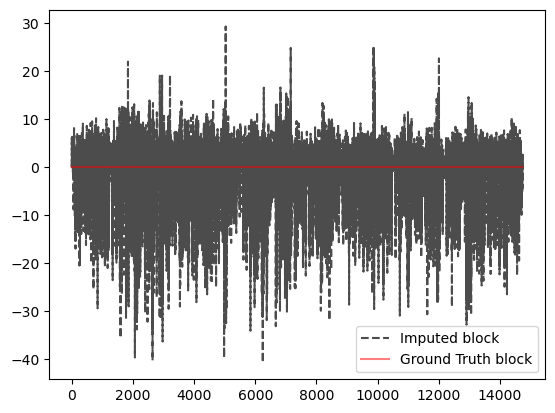

RMSE: 6.456839243023936


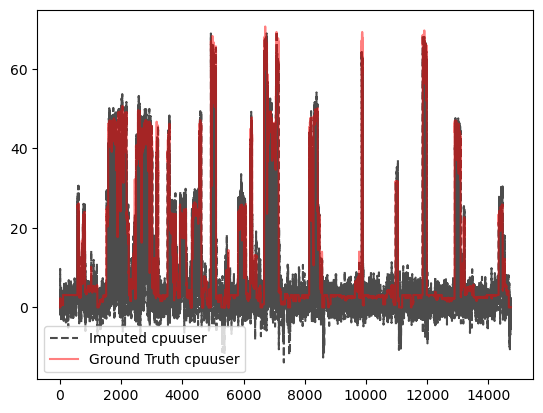

RMSE: 12.333327903402697


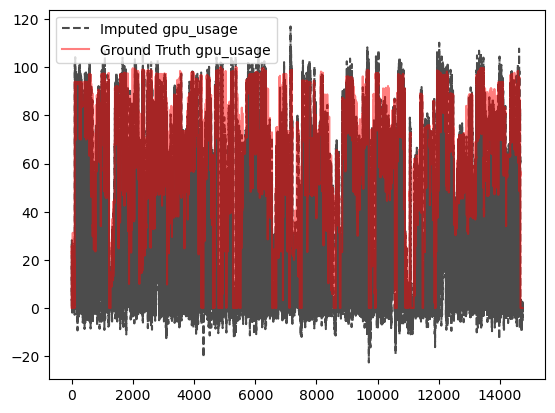

RMSE: 41.393408975833644


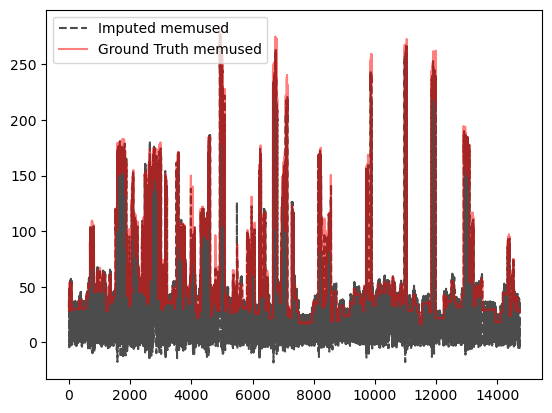

RMSE: 49.11830773038577


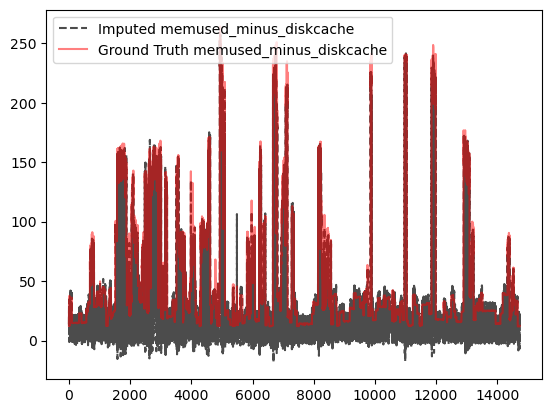

RMSE: 43.255929529408164


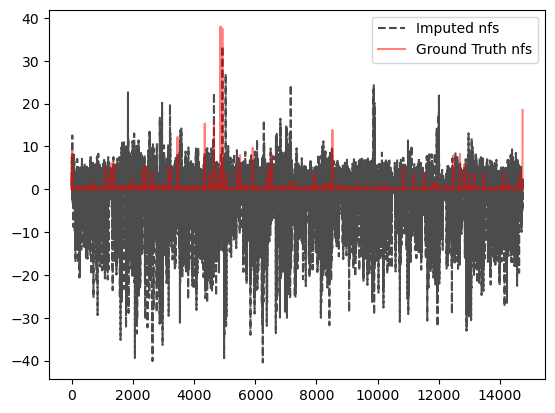

RMSE: 6.435173429035738
26.49883113518166


In [11]:
val_out = trainer_prediction_output_to_df(output=predictions, output2=predictions2, idx=0, features_list=forecast_columns, count=predictions[0][1].shape[0] , features=6)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
rmse = []
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  rmse_feature = math.sqrt(np.mean(errors_squared))
  rmse.append(rmse_feature)
  print(f"RMSE: {rmse_feature}")

print(np.mean(rmse))